# GMML - Poincaré embeddings
    Author : Léa Bresson
    

The aim of this notebook is to implement the algorithm introduced in 2017 by Maximilian Nickel and Douwe Kiela in the paper ["**Poincaré Embeddings for Learning Hierarchical Representations**"](https://arxiv.org/pdf/1705.08039.pdf). More precisely, I focus on **Taxonomies Embeddings**. I made slight modifications in order to improve the algorithm based on the blog post https://rare-technologies.com/implementing-poincare-embeddings.

Since *(i)* the official implementation of Poincaré embeddings ([link](https://github.com/facebookresearch/poincare-embeddings)) is done using Pytorch and *(ii)* the Gensim implementation uses Numpy ([link](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/poincare.py)), I decided to use **Keras**.


### Table of content
[1. Set up](#1)<br>
[2. Learning Poincaré embeddings](#2)<br>
[3. Keras customized SGD implementation](#3)<br>
[4. Results -Vizualization](#4)<br>
[5. Conclusions](#5)<br>
[6. References](#6)<br>



<a id='1'></a>
# 1. Set up

First of all, we import required python libraries and the dataset.

## Imports python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import random
import nltk
from nltk.corpus import wordnet as wn
import keras
from  keras.layers import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
import keras.backend as K

%matplotlib inline

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import Mammal dataset

I use the same dataset as the authors, i.e. the mammal dataset from WordNet.

In [2]:
target = wn.synset('mammal.n.01')
print("Definition:", target.definition())

Definition: any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk


## Prepare dataframe with word pairs

I focus on WordNet noun hypernym paires, which is the simplest hierarchical relationship to model.
The code for building hypernym paires is largely inspired from https://github.com/TatsuyaShirakawa/poincare-embedding.
Each line of the *hypernyms_df* dataset consists of a single unique relation among two mammalian animals.

In [3]:
def get_hypernym(target='mammal.n.01'):

    target = wn.synset(target)
    words = wn.words()
    nouns = set([])
    print('Updating noun set...')
    
    for word in words:
        nouns.update(wn.synsets(word, pos='n'))
    print(len(nouns), 'nouns')

    hypernyms = []
    hypernyms_connections = []
    print('Getting hypernyms...')
    for noun in nouns:
        paths = noun.hypernym_paths()
        for path in paths:
            try:
                pos = path.index(target)
                for i in range(pos, len(path)-1):
                    hypernyms.append((noun, path[i]))
                    hypernyms_connections.append((path[i], path[i+1])) 
            except Exception:
                continue
    hypernyms = list(set(hypernyms))
    print(len(hypernyms), 'hypernyms')
    
    random.shuffle(hypernyms)
        
    #word_to_idx = {val: i for i, val in enumerate(hypernyms)}
    # Dataframe
    hypernyms = [(n1.name(), n2.name()) for n1, n2 in hypernyms]
    hypernyms_df = pd.DataFrame(hypernyms, columns=['A', 'B'])
    hypernyms_df.index.name = "id"
    corpus = set(hypernyms_df.A.unique()) | set(hypernyms_df.B.unique())
    word_to_idx = {w: i for i, w in enumerate(corpus)}
    idx_to_word = {i: w for i, w in enumerate(corpus)}

    print(len(word_to_idx), 'unique nouns')
    
    hypernyms_edge = [(n1.name(), n2.name()) for n1, n2 in hypernyms_connections]
    hypernyms_edge_df = pd.DataFrame(hypernyms_edge, columns=['from', 'to'])
    hypernyms_edge_df.index.name = "id"   
    
    return hypernyms_df, hypernyms_edge_df, word_to_idx, idx_to_word

hypernyms_df, hypernyms_con_df, word_to_idx, idx_to_word = get_hypernym(target='mammal.n.01')

Updating noun set...
82115 nouns
Getting hypernyms...
6542 hypernyms
1182 unique nouns


The Mammal dataset consists of 82,115 nouns and 6542 hypernymy relations.

In [4]:
hypernyms_df[:5]

,A,B
id,,
0,bengal_tiger.n.01,big_cat.n.01
1,hominid.n.01,mammal.n.01
2,boskop_man.n.01,hominid.n.01
3,napu.n.01,placental.n.01
4,bovine.n.01,ruminant.n.01


For keras: 

In [5]:
# Useful for Keras: Convert words to numbers
hypernyms_df.A = hypernyms_df.A.map(word_to_idx)
hypernyms_df.B = hypernyms_df.B.map(word_to_idx)
hypernyms_df[:5]

,A,B
id,,
0,135,499
1,1151,347
2,1047,1151
3,748,88
4,1098,491


In [6]:
x_train, y_train = hypernyms_df.values[:, 0], hypernyms_df.values[:, 1]
x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)
x_train.shape, y_train.shape

((6542, 1), (6542, 1))

<a id='2'></a>
# 2. Learning Poincaré embeddings


## Data Generator
First, we implement a data generator so that data are generated batch-by-batch. Moreover, the function below randomly samples 10 negative examples per positive example (``num_samples``).

In [7]:
def data_generator(x_data, y_data, num_samples=10, batch_size=64):
    """Data generator to return the set of u (target word), v (any hypernym for the target word) 
    and v' (negative examples).
    Samples 10 (parameter num_samples) negative examples v' per positive example u.
    """
    
    indices = np.array(list(range(x_data.shape[0])))
    while True:
        random_batch = np.random.choice(indices, batch_size, replace=False)
        x_batch = x_data[random_batch]
        y_batch = y_data[random_batch]
    
        x_samples = []
        random_batch = np.random.choice(indices, (batch_size, num_samples), replace=False)
        for b in range(batch_size):
            x_sample = x_data[random_batch[b]][:, 0]   
            if (np.where(x_batch[b, 0] == x_sample)[0].shape[0] == 0):
                x_sample[0] = x_batch[b, 0]
            x_samples.append(x_sample)        
        x_samples = np.array(x_samples)        
        yield [x_batch, y_batch, x_samples], y_batch            

In [8]:
num_samples = 10 # Given by the authors, page 6
num_words = len(word_to_idx) # Number of unique words

train_generator = data_generator(x_train, y_train, num_samples=num_samples)

## Initialization 

We now define functions for initializing our model. Here $u$ is a target word, $v$ is any hypernym for that word, $v'$ is a set of randomly sampled words (see function above).


### - The Poincaré distance

Let $\mathcal{B}^d = \left \{x \in \mathbb{R}^d \; | \;
||x||<1  \right \}$ the open $d$-dimensional unit ball. 
The hyperbolic distance between two points  $u,v \in  \mathcal{B}^d$ is given as \begin{equation}
 d(u,v) = \text{arcosh} \Big ( 1 + 2 \frac{||u-v||^2} {(1-||u||^2)(1-||v||^2)} \;\Big ). 
\end{equation} 

### - The loss

We want to minimize the following loss function with respect to $\Theta$
$$
    \mathcal{L}(\Theta) = \sum_{(u,v)\in\mathcal{D}} \ln \frac{ e^{-d(u,v)} } {\sum_{v’ \in \mathcal{N}(u)} e^{-d(u,v’)}} 
$$
where $\mathcal{N}(u) =  \left \{ v’ | (u,v’) \notin \mathcal{D} \right \} \cup  \left \{ v \right \} $  is the set of negative examples for $u$ with $\mathcal{D} = \left \{(u,v) \right \}$ the set of all observed hypernymy relations and $\mathcal{N}(u)$ the set of negative examples for $u$. 





Note, we also need to define the identity loss. This identity loss will be plugged in order to be able to use the Keras API to train the model.


In [9]:
eps = 10**(-5) # Given by the authors, page 5

def arcosh(x):    
    return K.log(x + K.sqrt( K.square(x) - 1 ))

def l2(x):
    """L2 norm - used for computing hyperbolic distance.
    """    
    square_sum = K.sum(K.square(x), -1)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))
    return norm

def distance(x):
    """Hyperbolic distance (Equation 1 of the paper).
    """
    u, v = x
    num = l2(u-v)**2
    deno =  (1-l2(u)**2) * (1-l2(v**2)) + K.epsilon()
    distance = 1 + 2*num / deno
    d = arcosh(distance)
    return d

def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    This is a hack to work-around the design of the Keras API that is
    not really suited to train the model defined by Nickel and Kiela.
    """
    return tf.reduce_mean(y_pred + 0 * y_true)

def our_loss(x):
    """Loss for Embedding taxonomies (Equation 5 of the paper).
    """
    pos_distance, neg_distance = x
    num = K.exp(-pos_distance) 
    deno = K.sum(K.exp(-neg_distance),-1, keepdims=True)  
    return -K.log(num/deno)

## The Embedding layer in Keras

Let's use the embedding layer as a part of a Keras model.

In [10]:
def build_models(output_dim, input_dim, l2_reg=0):
    """Build the model computing embedding using the loss and distance functions defined above.
    """
    # Input placeholders
    u_input = Input(shape=[1], name='u_input')
    v_input = Input(shape=[1], name='v_input')
    neg_samples = Input(shape=[num_samples], name='neg_samples')

    # L2 regularization
    l2_reg = None if l2_reg == 0 else regularizers.l2(l2_reg)
    
    # The following embedding parameters will be shared to encode both the positive and negative 
    embedding_layer = Embedding(output_dim=output_dim, input_dim=input_dim, input_length=1, W_regularizer=l2_reg, name='my_embedding') #my_embedding
    embedding_u = embedding_layer(u_input)
    embedding_v = embedding_layer(v_input)
    embedding_neg = embedding_layer(neg_samples)  # SET OF NEGAFATIVES EX FOR U 
 
    # Similarity computation between embeddings
    pos_distance = Lambda(distance)([embedding_u, embedding_v])
    neg_distance = Lambda(distance)([embedding_u, embedding_neg])
    customized_loss = Lambda(our_loss)([pos_distance, neg_distance])
    
    # Model used for training
    model = Model([u_input,
                   v_input,
                   neg_samples],
                  customized_loss) 
    embedding_layer.set_weights([embedding_layer.get_weights()[0]*0.01]) # Initialization
    
    return model

model = build_models(output_dim=2, input_dim=num_words, l2_reg=1e-6)

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]


As recommanded in the [blog post](https://rare-technologies.com/implementing-poincare-embeddings), we add a regularization parameter ``l2_reg``. It prevents overfitting (vectors are too close to the boundary).

<a id='3'></a>
# 3. Keras customized SGD implementation

## An alternative update rule with keras

We implement a SGD alternative update rule with keras using keras.backend. To do so, I copy the SGD source code (https://github.com/keras-team/keras/blob/master/keras/optimizers.py) and add some modifications in order to introduce the burn-in period and reproduce the following update rule.

$$
\theta_{t+1} \leftarrow  proj \Big ( \theta_t - \eta_t \frac{ (1-||\theta_t||^2)^2} {4} \nabla_E \Big) .
$$
With the unit sphere projection defined as
$ \text{proj}(\theta) = \begin{cases}
               \frac{\theta}{||\theta||} - \epsilon \text{ if } ||\theta|| \ge 1\\
               \theta \text{ otherwise}
            \end{cases} $
so that the embeddings remain within the Poincaré ball after update.


In [11]:
def get_poincare_grad(p, g):
    """ Returns the Riemannian gradient. See Equation 4 of the paper.
    """
    L2sq_p = K.sum(K.square(p), -1, keepdims=True)
    pdt = K.square(1 - L2sq_p) / 4 
    return g * pdt  

def L2(x):
    square_sum = K.sum(K.square(x), -1, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))
    return norm

def proj(p):
    """ Projection operator. See Equation 4 of the paper.
    """
    p2 = K.sum(K.square(p), -1, keepdims=True)
    p_norm = L2(p)
    p_norm_clip = K.maximum(p_norm, 1.0)
    p_norm_cond = K.cast(p_norm > 1.0, dtype='float') * eps  
    return p/p_norm_clip - p_norm_cond


class SGD_custom(SGD):
    """Stochastic gradient descent optimizer CUSTOMIZED.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter that accelerates SGD
            in the relevant direction and dampens oscillations.
        decay: float >= 0. Learning rate decay over each update.
        burn_in: float >=0. Number of epochs with reduced learning rate.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0., burn_in=0.,
                 nesterov=False, **kwargs):
        super(SGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.burn_in = burn_in
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        lr = self.lr
        
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))
        ## Burn in period
        if self.burn_in > 0 :
            lr = K.switch(self.updates[-1]<self.burn_in, self.initial_lr / 10,
                       self.initial_lr)
    
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):

            ## New : Riemannian gradient
            g = get_poincare_grad(p, g)
            ## New : update rule
            v = self.momentum * m - lr * g  
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p + v
            ## New : Projetion
            new_p = proj(new_p)
            
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGD, self).get_config()
        
        return dict(list(base_config.items()) + list(config.items()))

## Training the model

We can now train our model.

In the following, I try different update rules:
- the one defined by the authors (see formula above), with and without with momentum
- the traditional SGD update rule, with L2 regularization or with momentum
- the Adam update rule, with and without regularization.

For the Riemannan and SGD update rules, I apply a L2 regularization term to the embeddings since it gives better results. Since regularization seems necessary, I decided to introduce momentum which helps accelerate SGD in the relevant direction and limits overfitting. Finally, based on these results, I decided to construct the embeddings using the Adam update rule (computes adaptive learning rates for each parameter).

Note : I tested different learning rate value, the value of 0.001 seemed to be the best compromise.

### a) Training the customized model

#### With L2 regularization

In [12]:
%%time
model1a = build_models(output_dim=2, input_dim=num_words, l2_reg=0)
model1a.compile(SGD_custom(lr=0.001), loss=identity_loss)
history = model1a.fit_generator(
  train_generator,
  steps_per_epoch=500,
  epochs=100, 
verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=None)`
  del sys.path[0]


Epoch 1/100
500/500 [==============================] - 2s 5ms/step - loss: 2.3024
Epoch 2/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3023
Epoch 3/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3023
Epoch 4/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3022
Epoch 5/100
500/500 [==============================] - 2s 4ms/step - loss: 2.3021
Epoch 6/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3020
Epoch 7/100
500/500 [==============================] - 2s 4ms/step - loss: 2.3020
Epoch 8/100
500/500 [==============================] - 2s 4ms/step - loss: 2.3018
Epoch 9/100
500/500 [==============================] - 2s 5ms/step - loss: 2.3017
Epoch 10/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3016
Epoch 11/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3014
Epoch 12/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3013
Epoch 13/100


500/500 [==============================] - 2s 3ms/step - loss: 2.2806
Epoch 100/100
500/500 [==============================] - 2s 3ms/step - loss: 2.2803
Wall time: 2min 52s


##### Monitoring runs

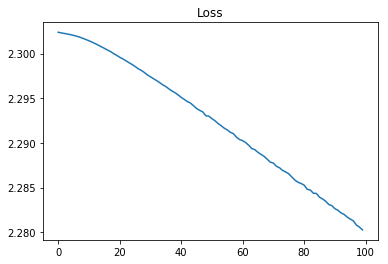

In [13]:
plt.plot(history.history['loss'], label='train')
plt.title('Loss');

#### With momentum

In [14]:
%%time
model1b = build_models(output_dim=2, input_dim=num_words, l2_reg=0.0) 
model1b.compile(SGD_custom(lr=0.001, momentum=0.8), loss=identity_loss)
history = model1b.fit_generator(
  train_generator,
  steps_per_epoch=500,
  epochs=100, verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=None)`
  del sys.path[0]


Epoch 1/100
500/500 [==============================] - 2s 5ms/step - loss: 2.3023
Epoch 2/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3019
Epoch 3/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3014
Epoch 4/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3007
Epoch 5/100
500/500 [==============================] - 2s 3ms/step - loss: 2.3000
Epoch 6/100
500/500 [==============================] - 2s 3ms/step - loss: 2.2991
Epoch 7/100
500/500 [==============================] - 2s 4ms/step - loss: 2.2982
Epoch 8/100
500/500 [==============================] - 2s 5ms/step - loss: 2.2972
Epoch 9/100
500/500 [==============================] - 2s 4ms/step - loss: 2.2962
Epoch 10/100
500/500 [==============================] - 2s 5ms/step - loss: 2.2952
Epoch 11/100
500/500 [==============================] - 2s 4ms/step - loss: 2.2940
Epoch 12/100
500/500 [==============================] - 2s 4ms/step - loss: 2.2929
Epoch 13/100


500/500 [==============================] - 2s 4ms/step - loss: 2.1841
Epoch 100/100
500/500 [==============================] - 2s 4ms/step - loss: 2.1833
Wall time: 3min 2s


### b) Traditional  SGD update rule

#### With L2 regularization

In [15]:
%%time

model2a = build_models(output_dim=2, input_dim=num_words, l2_reg=0.01)
model2a.compile(optimizer=SGD(0.001), loss=identity_loss)
history = model2a.fit_generator(
  train_generator,
  samples_per_epoch=500,
  epochs=50, verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]
C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, verbose=1, class_weight="auto", steps_per_epoch=500)`
  import sys


Epoch 1/50
500/500 [==============================] - 2s 5ms/step - loss: 2.3023
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3021
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3017
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3011
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3005
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 2.2999
Epoch 7/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2992
Epoch 8/50
500/500 [==============================] - 2s 4ms/step - loss: 2.2984
Epoch 9/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2977
Epoch 10/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2970
Epoch 11/50
500/500 [==============================] - 2s 4ms/step - loss: 2.2962
Epoch 12/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2954
Epoch 13/50
500/500 [====

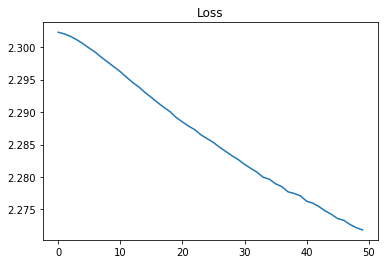

In [16]:
plt.plot(history.history['loss'], label='train')
plt.title('Loss');

#### With momentum

In [17]:
model2b = build_models(output_dim=2, input_dim=num_words, l2_reg=0)
model2b.compile(SGD(lr=0.001, momentum=0.8), loss=identity_loss)
history = model2b.fit_generator(
  train_generator,
  steps_per_epoch=500,
  epochs=50, verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=None)`
  del sys.path[0]


Epoch 1/50
500/500 [==============================] - 3s 5ms/step - loss: 2.3016
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2989
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2952
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2909
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2865
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2818
Epoch 7/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2769
Epoch 8/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2722
Epoch 9/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2674
Epoch 10/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2622
Epoch 11/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2575
Epoch 12/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2526
Epoch 13/50
500/500 [====

### c) Adam optimizer

In [18]:
%%time
# With L2 regularization
model3a = build_models(output_dim=2, input_dim=num_words, l2_reg=0.01) #1e-6
model3a.compile(Adam(0.001), loss=identity_loss)
history = model3a.fit_generator(
  train_generator,
  samples_per_epoch=500,
  epochs=50, verbose=1, class_weight='auto')

# Without L2 regularization
model3b = build_models(output_dim=2, input_dim=num_words, l2_reg=0.0) #1e-6
model3b.compile(Adam(0.001), loss=identity_loss)
history = model3b.fit_generator(
  train_generator,
  samples_per_epoch=500,
  epochs=50, verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=<keras.reg...)`
  del sys.path[0]
C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, verbose=1, class_weight="auto", steps_per_epoch=500)`
  import sys


Epoch 1/50
500/500 [==============================] - 3s 6ms/step - loss: 2.2875
Epoch 2/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2615
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2555
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2554
Epoch 5/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2546
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2537
Epoch 7/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2540
Epoch 8/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2542
Epoch 9/50
500/500 [==============================] - 1s 3ms/step - loss: 2.2536
Epoch 10/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2549
Epoch 11/50
500/500 [==============================] - 2s 5ms/step - loss: 2.2547
Epoch 12/50
500/500 [==============================] - 2s 4ms/step - loss: 2.2543
Epoch 13/50
500/500 [====

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=2, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=None)`
  del sys.path[0]
C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, verbose=1, class_weight="auto", steps_per_epoch=500)`
  from ipykernel import kernelapp as app


Epoch 1/50
500/500 [==============================] - 3s 7ms/step - loss: 2.2582
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 2.1801A: 0s - loss
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 2.1055
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 2.0421
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 1.9854
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 1.9356
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 1.8992
Epoch 8/50
500/500 [==============================] - 2s 5ms/step - loss: 1.8528
Epoch 9/50
500/500 [==============================] - 2s 3ms/step - loss: 1.8236
Epoch 10/50
500/500 [==============================] - 1s 3ms/step - loss: 1.7983
Epoch 11/50
500/500 [==============================] - 2s 3ms/step - loss: 1.7756TA: 0s - loss: 1.7
Epoch 12/50
500/500 [==============================] - 2s 3ms/step - loss: 1.

<a id='4'></a>
# 4. Results - Vizualization


Let's plot the embedding space!

Similar animals in the WordNet must be close to each other in the embedding space. In addition, the nodes close to the boundary are lower in the hierarchy.

*Note : The code for plotting (file plot.py) is taken from the C++ implementation of the Poincarré embeddings ([link](https://github.com/TatsuyaShirakawa/poincare-embedding)) and [link](https://github.com/fornaxai/WDYL/blob/bd33698e60db762d315ead57215884809eec4dce/2017.09.05_Poincare_Embeddings/notebooks/utils.py). The ``plot_embedding`` function above is from [link](https://github.com/fornaxai/WDYL/blob/bd33698e60db762d315ead57215884809eec4dce/2017.09.05_Poincare_Embeddings/notebooks/utils.py).*

In [19]:
from plot import plot_embeddings2d, plotly_embeddings2d, plotly_embeddings3d

In [20]:
edges_df = hypernyms_con_df
edges_df = edges_df.drop_duplicates()

def plot_embeddings(word_embd_layer, mode='plt', center=True):
    w_embd = word_embd_layer.get_weights()[0]
    words = list(map(lambda x: idx_to_word[x], range(num_words)))
    embeddings_df = pd.DataFrame( w_embd, columns=['x1', 'x2'], index=words)
    
    if mode == 'plt':
        plot_embeddings2d(embeddings_df, edges_df, center, center_node='mammal.n.01')  
    elif mode == 'plotly':
        plotly_embeddings2d(embeddings_df, edges_df, center)

def plot_embeddings3d(word_embd_layer):    
    w_embd = word_embd_layer.get_weights()[0]
    words = list(map(lambda x: idx_to_word[x], range(num_words)))
    embeddings_df = pd.DataFrame( w_embd, columns=['x1', 'x2', 'x3'], index=words)        
    plotly_embeddings3d(embeddings_df, edges_df)

## a) Customized SGD

28  targets found


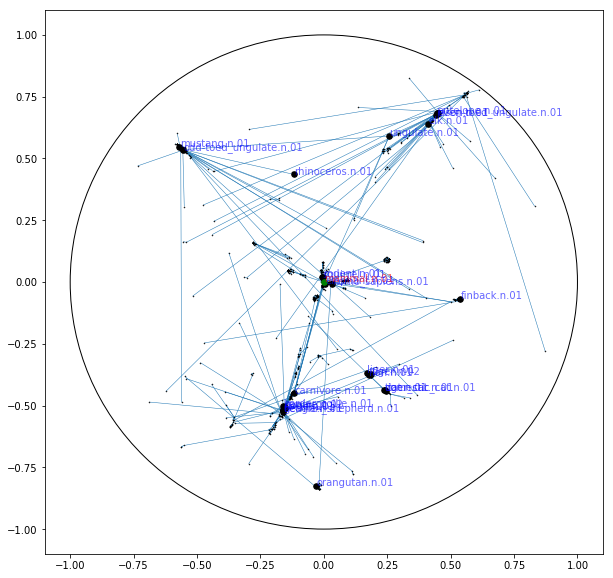

28  targets found


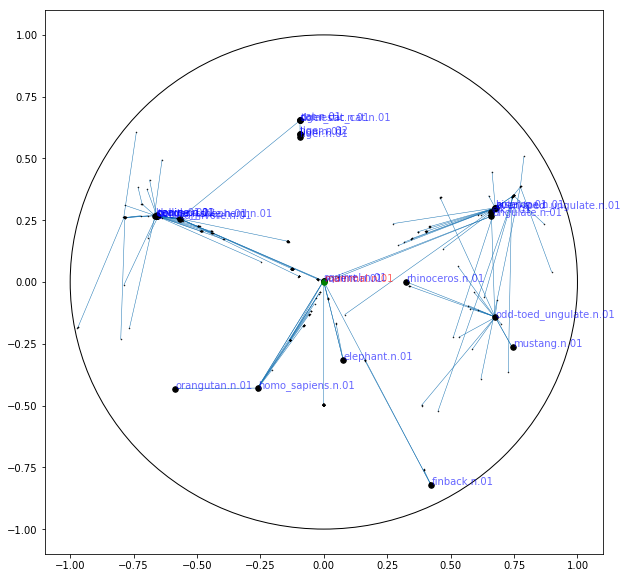

In [21]:
listmod = [model1a, model1b]
for k in listmod:
    plot_embeddings(k.get_layer('my_embedding'), mode ='plt', center = True)
# model1a : without momentum
# model1b : with momentum

## b) SGD

28  targets found


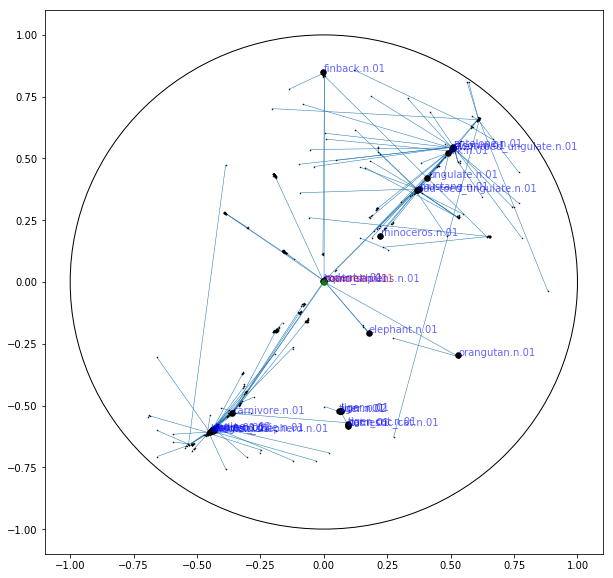

28  targets found


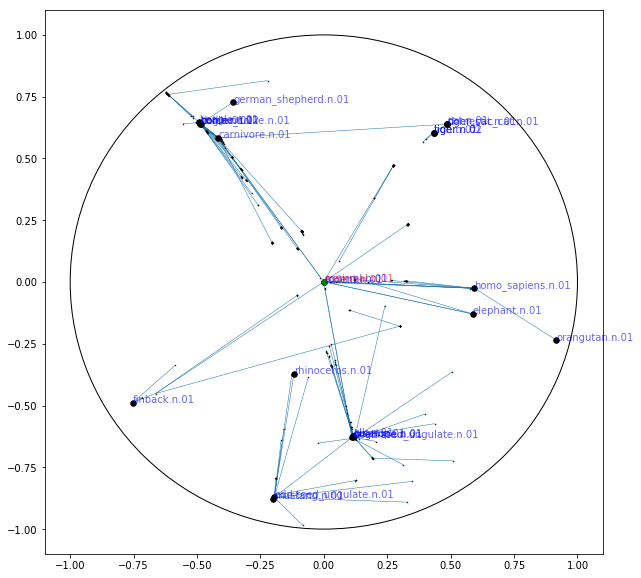

In [22]:
listmod = [model2a, model2b]
for k in listmod:
    plot_embeddings(k.get_layer('my_embedding'), mode ='plt', center = True)
    
#model2a : with L2 regularization
#model2b : with momentum

## c) Adam

28  targets found


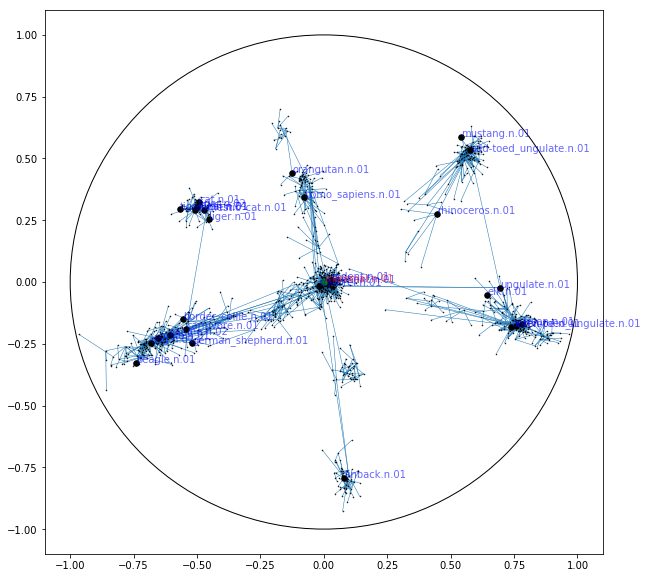

28  targets found


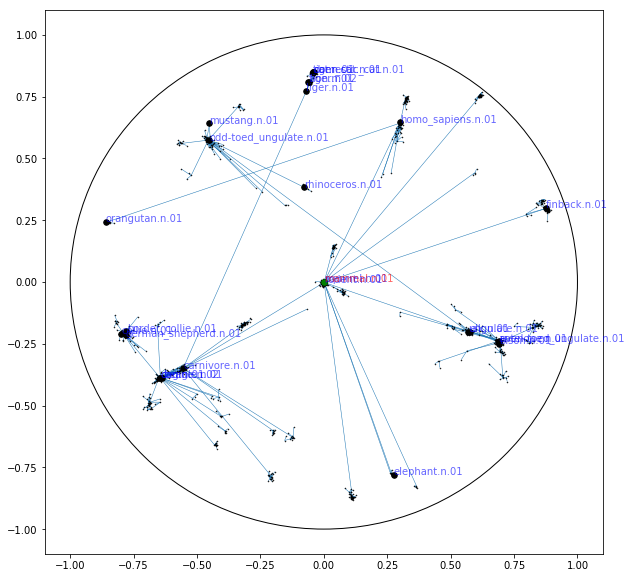

In [23]:
listmod = [model3a, model3b]
for k in listmod:
    plot_embeddings(k.get_layer('my_embedding'), mode ='plt', center = True)
    
# Model3a: with L2 regularization
# Model3b : without L2 regularization

In [25]:
plot_embeddings(model3b.get_layer('my_embedding'), mode ='plotly', center = True)

## 3d visualization

The best representation is given by the Adam optimization algorithm. Let's plot the results in 3D:

In [26]:
%%time

# Without L2 regularization
model3d = build_models(output_dim=3, input_dim=num_words, l2_reg=0.0)
model3d.compile(Adam(0.001), loss=identity_loss)
history = model3d.fit_generator(
  train_generator,
  samples_per_epoch=500,
  epochs=50, verbose=1, class_weight='auto')

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning:

Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=3, input_dim=1182, input_length=1, name="my_embedding", embeddings_regularizer=None)`

C:\Users\asus\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, verbose=1, class_weight="auto", steps_per_epoch=500)`



Epoch 1/50
500/500 [==============================] - 3s 7ms/step - loss: 2.2448
Epoch 2/50
500/500 [==============================] - 2s 3ms/step - loss: 2.1364
Epoch 3/50
500/500 [==============================] - 2s 3ms/step - loss: 2.0358
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 1.9508
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 1.8800
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 1.8194
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 1.7724
Epoch 8/50
500/500 [==============================] - 2s 4ms/step - loss: 1.7340
Epoch 9/50
500/500 [==============================] - 2s 3ms/step - loss: 1.7171
Epoch 10/50
500/500 [==============================] - 2s 4ms/step - loss: 1.6885
Epoch 11/50
500/500 [==============================] - 2s 3ms/step - loss: 1.6713
Epoch 12/50
500/500 [==============================] - 2s 3ms/step - loss: 1.6644
Epoch 13/50
500/500 [====

In [27]:
plot_embeddings3d(model3d.get_layer('my_embedding'))

<a id='5'></a>
# 5. Conclusion

To conclude learning embeddings in a hyperbolic plane, rather than Euclidan space, allows to capture not only semantic, but also hierarchical structure of the data. This improves the quality of the learned representations while also reducing the number of dimensions needed to obtain a good representation.

My implementations suggest that traditional optimization approaches such as SGD or Adam converge faster and give similar results as a full Riemannian optimization approach.


<a id='6'></a>
# 6. References

This notebook is inspired from :
- https://github.com/TatsuyaShirakawa/poincare-embedding
- https://github.com/fornaxai/WDYL/tree/bd33698e60db762d315ead57215884809eec4dce/2017.09.05_Poincare_Embeddings/notebooks

- https://github.com/facebookresearch/poincare-embeddings
- https://github.com/qiangsiwei/poincare_embedding
- https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/poincare.py